Doc2vec model with small finetuning built on the dataset of 35k quotes


In [1]:
#preprocessing libriaris
import nltk
nltk.download("stopwords")
#stopwords modules
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation

import pandas as pd
import numpy as np
import io

import gensim

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Create lemmatizer and stopwords list
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")

#Preprocess function (stopwords, puncuation, etc)
def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords \
              and token not in [" ","\n", "…"] \
              and all((c not in token.strip()) for c in punctuation)] 
    text = " ".join(tokens)
    
    return text


In [3]:
#loading dataset
qoutes_path = '../parsing/data/big_data.csv'

df_35k = pd.read_csv(qoutes_path, sep=',', engine ='python') #reading quotes to the dataframe
df_35k.drop_duplicates(subset="citation", keep = 'first', inplace = True)
df_35k.reset_index(drop=True, inplace = True)

In [4]:
df_35k

,Unnamed: 0,Unnamed: 0.1,id,citation,author,raw_tags,tags,strlen,num_words
0,0,0,0,Предпочитая быть романтиком во время тягостны...,Игорь Губерман,"['юмор', 'олюбвисулыбкой']","['юмор', 'олюбвисулыбкой']",112,17
1,1,1,1,"Чужую беду ощущая своей, вживаясь в чужие печа...",Игорь Губерман,"['ирония', 'стихи']","['ирония', 'стихи']",116,19
2,2,2,2,"Обманчива наша земная стезя, Идешь то туда, то...",Игорь Губерман,"['жизнь', 'стихи', 'осознание']","['жизнь', 'стихи', 'осознание']",122,22
3,3,3,3,"Жить, покоем дорожа, — пресно, тускло, просток...",Игорь Губерман,"['жизнь', 'стихи', 'душа']","['жизнь', 'стихи', 'душа']",103,15
4,4,4,4,"Все предрассудки прочь отбросив, Но чтоб от Бо...",Игорь Губерман,"['стихи', 'предрассудкииразум']","['стихи', 'предрассудкииразум']",111,19
...,...,...,...,...,...,...,...,...,...
34478,35004,35004,35004,"Каждый имеет в сердце свое «кладбище», куда ни...",Чингиз Абдуллаев,"['боль', 'сомнения', 'страхи', 'сердце']","['боль', 'сомнения', 'страхи', 'сердце']",116,20
34479,35005,35005,35005,Мужчина и женщина равны. Абсолютно равны. Полн...,Чингиз Абдуллаев,"['отношения', 'чувства']","['отношения', 'чувства']",177,29
34480,35006,35006,35006,"Для женщины важен сам факт, что ей хотят сдела...",Чингиз Абдуллаев,"['отношения', 'цитаты']","['отношения', 'цитаты']",164,28
34481,35007,35007,35007,"Для мужчины нормально, если он защищает женщин...",Чингиз Абдуллаев,"['жизнь', 'женщины', 'мужчина']","['жизнь', 'женщины', 'мужчина']",248,37


In [177]:
df_35k.rename(columns={'citation': 'quotes'}, inplace=True)
df_35k['quotes'].to_csv('processed_data/pure_q_35k.csv', index=False)
df = pd.read_csv('processed_data/pure_q_35k.csv', sep='<\d*>', engine ='python') #reading quotes to the dataframe
with open('processed_data/pure_q_35k.csv', 'r', encoding='utf-8') as file:
    data = file.read().replace('\n', ' nextquote ')
    processed_data = preprocess_text(data)  #preprocessing qoutes
#dataframe with quotes and their processed versions
df.insert(loc=1, column='processed_quotes', value=processed_data.split('nextquote')[1:-1], allow_duplicates=False) 
df

,quotes,processed_quotes
0,"""Предпочитая быть романтиком во время тягостн...",предпочитать романтик время тягостный реше...
1,"""Чужую беду ощущая своей, вживаясь в чужие печ...",чужой беда ощущать свой вживаться чужой печал...
2,"""Обманчива наша земная стезя, Идешь то туда, т...",обманчивый наш земной стезя идти туда обратно...
3,"""Жить, покоем дорожа, — пресно, тускло, просто...",жить покой дорожить пресный тускло простокваш...
4,"""Все предрассудки прочь отбросив, Но чтоб от Б...",весь предрассудок прочь отбрасывать бог секре...
...,...,...
34478,"""Каждый имеет в сердце свое «кладбище», куда н...",каждый иметь сердце свой « кладбище никто пу...
34479,"""Мужчина и женщина равны. Абсолютно равны. Пол...",мужчина женщина равный абсолютно равный полно...
34480,"""Для женщины важен сам факт, что ей хотят сдел...",женщина важный факт хотеть сделать приятный м...
34481,"""Для мужчины нормально, если он защищает женщи...",мужчина нормально защищать женщина любить всп...


In [5]:
df

NameError: name 'df' is not defined

In [179]:
df.to_csv('processed_data/pure_q_35k.csv', index=False)

In [6]:
df_pure35k = pd.read_csv('processed_data/pure_q_35k.csv', sep=',', engine ='python')
df_pure35k

,quotes,processed_quotes
0,"""Предпочитая быть романтиком во время тягостн...",предпочитать романтик время тягостный реше...
1,"""Чужую беду ощущая своей, вживаясь в чужие печ...",чужой беда ощущать свой вживаться чужой печал...
2,"""Обманчива наша земная стезя, Идешь то туда, т...",обманчивый наш земной стезя идти туда обратно...
3,"""Жить, покоем дорожа, — пресно, тускло, просто...",жить покой дорожить пресный тускло простокваш...
4,"""Все предрассудки прочь отбросив, Но чтоб от Б...",весь предрассудок прочь отбрасывать бог секре...
...,...,...
34478,"""Каждый имеет в сердце свое «кладбище», куда н...",каждый иметь сердце свой « кладбище никто пу...
34479,"""Мужчина и женщина равны. Абсолютно равны. Пол...",мужчина женщина равный абсолютно равный полно...
34480,"""Для женщины важен сам факт, что ей хотят сдел...",женщина важный факт хотеть сделать приятный м...
34481,"""Для мужчины нормально, если он защищает женщи...",мужчина нормально защищать женщина любить всп...


In [10]:
quote_tokens = [q.split() for q in df_pure35k['processed_quotes'].values.tolist()]
quote_words = [q for q in df_pure35k['quotes'].values.tolist()]

In [11]:
#preparing data for doc2vec
def tagged_document(list_of_list_of_words):
    for i, list_of_words in enumerate(list_of_list_of_words):
        yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])
quotes_for_training = list(tagged_document(quote_tokens))

In [352]:
#buiding a model
#model = gensim.models.doc2vec.Doc2Vec(vector_size=50, dm=1, window=4, min_count=1, negative=5, epochs=30, workers=4)
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=1, window=8, dbow_words=1, negative=5, epochs=30, workers=4, sample=10e-5)

model.build_vocab(quotes_for_training)

model.train(quotes_for_training, total_examples=model.corpus_count, epochs=model.epochs)

In [196]:
model.save('models/d2v_35k_exp.model')

In [197]:
model_35k_exp = gensim.models.doc2vec.Doc2Vec.load('models/d2v_35k_exp.model')

In [23]:
#request handling
def request_processing():
    request = preprocess_text(input()).split()
    return request

In [24]:
def cluster_check(sim, df, model):
    avg = sum([sim_coef for docid, sim_coef in sim])/len(sim)
    cluster_coef=[]
    for q in sim:
        q_sim = model.dv.most_similar(model.infer_vector(df['processed_quotes'][q[0]].split()), topn=len(df))
        q_dict = {}
        q_dict = dict(q_sim)
        q_sim_sim = [q_dict[docid] for docid, sim_coef in sim if docid != q[0]]
        cluster_coef.append((q[0],sum(q_sim_sim)/len(q_sim_sim)))
    return avg, cluster_coef

In [126]:
Q_NUMBER=10
request = request_processing()
"""
sim = model.dv.most_similar(model.infer_vector(request, epochs=30), topn=Q_NUMBER)
avg, cluster_coefs = cluster_check(sim, df_pure35k, model)
cluster_dict = dict(cluster_coefs)
print(avg)
for quote in sim:
    print(quote_words[quote[0]], round(quote[1], 3), round(cluster_dict[quote[0]], 3), '\n', df_35k['author'][quote[0]])

print("--------------------------------------------vs old---------------------------------------------------")
"""

sims = model_35k_exp.dv.most_similar(model_35k_exp.infer_vector(request, epochs=30), topn=Q_NUMBER)
avg, cluster_coefs = cluster_check(sims, df_pure35k, model_35k_exp)
cluster_dict = dict(cluster_coefs)
print(avg)
for quote in sims:
    print(quote_words[quote[0]], round(quote[1], 3), round(cluster_dict[quote[0]], 3))


KeyboardInterrupt: Interrupted by user

Далее идут эксперименты по визуализации:

In [169]:
sum(model.infer_vector(['радость любовь разлука печаль'], epochs=30))

-0.018196565593825653

In [282]:
def show_importance(string, model, out=False):
    """
    string - str, user input,
    model - class:`~gensim.models.doc2vec.Doc2Vec,
    
    return:
    list of the coeffs of the importance correspondig to the tagged representation of the string
    """
    importances = []
    
    if isinstance(string, str):
        tagged = preprocess_text(string).split()
    elif isinstance(string, list):
        tagged = string
        
    for word in tagged:
        eliminated = [w for w in tagged if w != word]
        coef = 1 - model.similarity_unseen_docs(eliminated, tagged, epochs=30)
        importances.append(coef)
    s = sum(importances)
    importance = [np.around(i/s, 3) for i in importances]
    if out:
        print(*["{} {}".format(tagged[i], importance[i]) for i in range(len(tagged))])
    return importance

In [28]:
def print_meaningful(string, model):
    """
    Caution, works inproperly!
    
    string - str, user input,
    model - class:`~gensim.models.doc2vec.Doc2Vec,
    
    printing:
    string inserting correspondig coeffs of the importance
    """
    tagged = preprocess_text(string).split()
    str_words = string.split()
    coefs = show_importance(string, model)
    result = ""
    i=0    
    for word in str_words:        
        tag_word = preprocess_text(word)
        if tag_word in tagged:
            result +=" ".join([word, "({})".format(coefs[i])])
            #print(word, "({})".format(coefs[i]), end=' ')
            i+=1
        else:
            result+=" "+word+" "
            #print(word, end=' ')
    if i != len(tagged):
        print("Возникла проблема с печатью текста...")
        print(*["{} {}".format(tagged[i], coefs[i]) for i in range(len(tagged))])
    else: 
        print(result)
    print('\n')

In [191]:
print_meaningful("жизнь на то и жизнь, а не пустота", model_35k_exp)
print_meaningful("жизнь на то и жизнь, а не пустота", model)

жизнь (0.322) на  то  и жизнь, (0.22) а  не пустота (0.458)


жизнь (0.322) на  то  и жизнь, (0.22) а  не пустота (0.458)




In [283]:
s1 = "бывает и бред пишу"
#s2="первая любовь как снег на голову - никогда не думал, что встречу ее так поздно и в лифте"
show_importance(s1, model_35k_exp, True)
#show_importance(s2, model, True)

бывать 0.265 бред 0.129 писать 0.607


[0.265, 0.129, 0.607]

In [41]:
preprocess_text("Не стоит принимать близко к сердцу то, что можно послать в жопу...")

'стоить принимать близко сердце посылать жопа'

In [333]:
model1 = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=1, window=8, dbow_words=1, negative=5, epochs=30, workers=4, sample=10e-5)

model1.build_vocab(quotes_for_training)
model1.scan_vocab(quotes_for_training)

(347592, 34483)

In [344]:
vocab = {k: v for k, v in sorted(model1.raw_vocab.items(), key=lambda item: item[1], reverse=True)}
len(vocab)

23589

In [178]:
vocab

{'человек': 6646,
 'это': 5732,
 'жизнь': 3607,
 'весь': 3210,
 'который': 3145,
 'свой': 3104,
 'любовь': 2929,
 'мочь': 2922,
 'любить': 2685,
 'женщина': 2582,
 'знать': 1835,
 'самый': 1766,
 '»': 1718,
 'жить': 1694,
 'друг': 1601,
 'мир': 1524,
 '«': 1497,
 'хотеть': 1486,
 'душа': 1440,
 'становиться': 1381,
 'каждый': 1356,
 'мужчина': 1352,
 'наш': 1331,
 'ничто': 1315,
 'говорить': 1300,
 'хороший': 1299,
 'время': 1286,
 'делать': 1156,
 'сердце': 1133,
 'твой': 1111,
 'счастие': 1101,
 'понимать': 1047,
 'лишь': 991,
 'давать': 982,
 'слово': 966,
 'сказать': 937,
 'день': 926,
 'думать': 914,
 'иметь': 876,
 'дело': 829,
 'просто': 825,
 'свет': 822,
 'бог': 813,
 'никто': 795,
 'должный': 782,
 'видеть': 719,
 'сделать': 718,
 'оставаться': 702,
 'год': 697,
 'нужно': 683,
 'очень': 676,
 'бывать': 635,
 'счастливый': 615,
 'сила': 614,
 'глаз': 612,
 'чувство': 610,
 'рука': 609,
 'идти': 601,
 'ваш': 600,
 'ум': 595,
 'оно': 593,
 'верить': 591,
 'мысль': 591,
 'ребенок

In [201]:
import matplotlib.pyplot as plt
import random

Визуализация значения модуля вектора цитаты, исследование зависимости важности слова от чатсоты вхождения в словарь

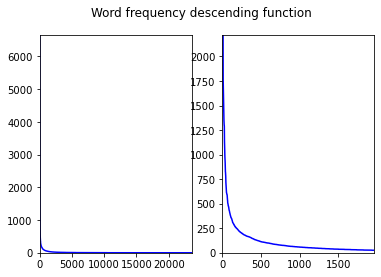

In [109]:
fig, axs = plt.subplots(1, 2)
fig.suptitle('Word frequency descending function')
axs[0].plot([i for i in range(len(vocab))], vocab.values(), 'blue')
axs[0].axis([0, len(vocab), 0, max(vocab.values())])
axs[1].plot([i for i in range(len(vocab))], vocab.values(), 'blue')
axs[1].axis([0, len(vocab)/12, 0, max(vocab.values())/3])
plt.show()

In [346]:
vec_mod = [sum(model_35k_exp.dv[i]**2) for i in range(len(model_35k_exp.dv))]
#word_occur = []
sorted(vec_mod)[len(model_35k_exp.dv)-1]

11.057653952782857

In [383]:
vectors = {i: model_35k_exp.dv[i] for i in range(len(model_35k_exp.dv))}
vocab = {k: v for k, v in sorted(model1.raw_vocab.items(), key=lambda item: item[1], reverse=True)}

sort_vec_mod = {k: sum(v) for k, v in sorted(vectors.items(), key=lambda item: sum(item[1]))}
sort_vec_sqr = {k: sum(v**2) for k, v in sorted(vectors.items(), key=lambda item: sum(item[1]**2))}

lengths = [len(quote_words[i].split()) for i in list(sort_vec_sqr)]

word_popularity1 = [sum([vocab.get(word, 0) for word in quote_tokens[i]])/len(quote_words[i].split()) for i in list(sort_vec_mod)]
word_popularity2 = [sum([vocab.get(word, 0) for word in quote_tokens[i]])/len(quote_words[i].split()) for i in list(sort_vec_sqr)]

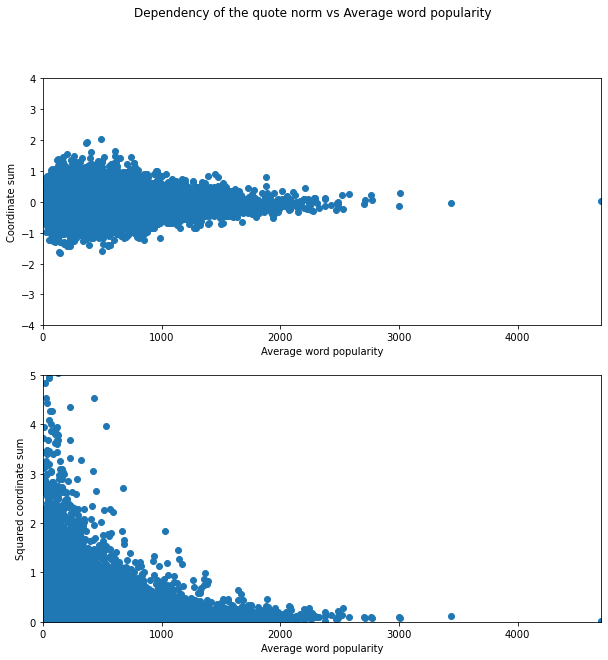

In [384]:
fig, axs = plt.subplots(2,figsize=(10, 10))
fig.suptitle('Dependency of the quote norm vs Average word popularity')

axs[0].scatter(word_popularity1, sort_vec_mod.values())
axs[0].axis([0, max(word_popularity1), -4, 4])
axs[0].set(xlabel='Average word popularity', ylabel='Coordinate sum')

axs[1].scatter(word_popularity2, sort_vec_sqr.values())
axs[1].axis([0, max(word_popularity2), 0, 5])
axs[1].set(xlabel='Average word popularity', ylabel='Squared coordinate sum')

plt.show()

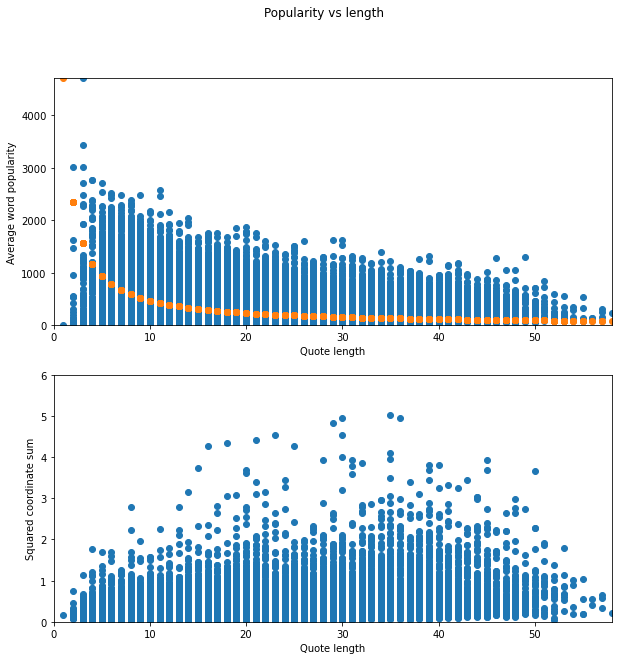

In [385]:
fig, axs = plt.subplots(2,figsize=(10, 10))
fig.suptitle('Popularity vs length')

axs[0].scatter(lengths, word_popularity2)
axs[0].axis([0, max(lengths), 0, max(word_popularity2)])
axs[0].set(xlabel='Quote length', ylabel='Average word popularity')

max_pop = max(word_popularity2)
axs[0].scatter(lengths, [max_pop/lengths[i] for i in range(len(lengths))])
axs[0].axis([0, max(lengths), 0, max(word_popularity2)])

axs[1].scatter(lengths, sort_vec_sqr.values())
axs[1].axis([0, max(lengths), 0, 6])
axs[1].set(xlabel='Quote length', ylabel='Squared coordinate sum')

plt.show()

In [366]:
model_no_threshold = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=1, window=8, dbow_words=1, negative=5, epochs=30, workers=4)

model_no_threshold.build_vocab(quotes_for_training)

model_no_threshold.train(quotes_for_training, total_examples=model_no_threshold.corpus_count, epochs=model_no_threshold.epochs)

In [367]:
vectors_exp = {i: model_no_threshold.dv[i] for i in range(len(model.dv))}

word_popularity3 = [sum([vocab.get(word, 0) for word in quote_tokens[i]]) for i in list(sort_vec_sqr)]
sort_vec_sqr_exp = {k: sum(v**2) for k, v in sorted(vectors_exp.items(), key=lambda item: sum(item[1]**2))}

word_popularity4 = [sum([vocab.get(word, 0) for word in quote_tokens[i]]) for i in list(sort_vec_sqr_exp)]

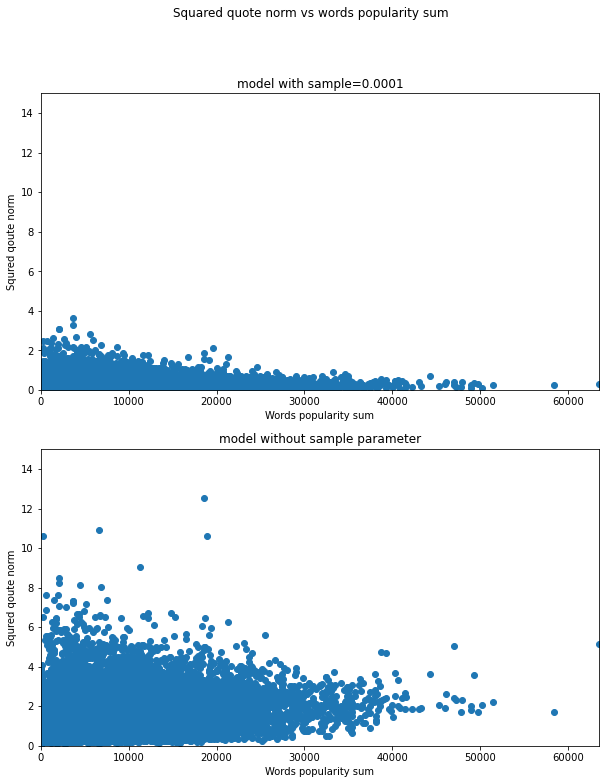

In [378]:
fig, axs = plt.subplots(2,figsize=(10, 12))
fig.suptitle('Squared quote norm vs words popularity sum')

axs[0].scatter(word_popularity3, sort_vec_sqr.values())
axs[0].axis([0, max(word_popularity3), 0, 15])
axs[0].set(xlabel='Words popularity sum', ylabel='Squred qoute norm')
axs[0].set_title("model with sample=0.0001")

axs[1].scatter(word_popularity4, sort_vec_sqr_exp.values())
axs[1].axis([0, max(word_popularity4), 0, 15])
axs[1].set(xlabel='Words popularity sum', ylabel='Squred qoute norm')
axs[1].set_title("model without sample parameter")
plt.show()

In [274]:
def diff_pop_imp(vocab, model, number=100):
    """
    Show squared difference between percentages of the relative popularity and the relative importance of words in qoutes
    
    Parameters
    ----------
    vocab : dict of (str, int)
            Word <-> count mapping.
    model : class:`~gensim.models.doc2vec.Doc2Vec`.
    
    number : 
    
    ----------
    
    """
    vec_sample = {i: model.dv[i] for i in random.sample(range(0, len(model.dv)-1), number)}
    sort_sqr_sample = {k: sum(v**2) for k, v in sorted(vec_sample.items(), key=lambda item: sum(item[1]**2))}
    diff_pop_importance = []
    for i in list(sort_sqr_sample):
        importance = show_importance(quote_tokens[i], model)
        pop_vec = [vocab.get(quote_tokens[i][word_num], 0) for word_num in range(len(quote_tokens[i]))]
        sum_pop_vec = sum(pop_vec)
        sqr_diff = sum([(pop_vec[i]/sum_pop_vec - importance[i])**2 for i in range(len(quote_tokens[i]))])
        diff_pop_importance.append(sqr_diff)
    return diff_pop_importance


In [278]:
mod = model_no_threshold
diff = diff_pop_imp(vocab, mod, number=100)
sum(diff)/len(diff)

0.29039380376611756

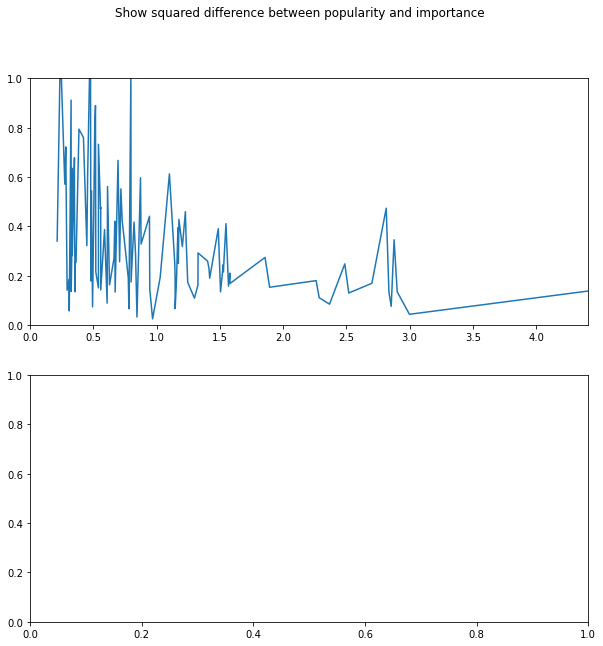

In [272]:
fig, axs = plt.subplots(2,figsize=(10, 10))
fig.suptitle('Show squared difference between popularity and importance')

axs[0].plot(sort_sqr_sample.values(), diff_pop_importance)
axs[0].axis([0, max(sort_sqr_sample.values()), 0, 1])

plt.show()

In [292]:
sample = 10e-8
rep = 5
loggs = []
averege_diff = []
while sample < 10:
    model_no_threshold = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=1, window=8, dbow_words=1, negative=5, epochs=30, workers=4, sample=sample)
    model_no_threshold.build_vocab(quotes_for_training)
    model_no_threshold.train(quotes_for_training, total_examples=model_no_threshold.corpus_count, epochs=model_no_threshold.epochs)
    mean_diff = 0
    for i in range(rep):
        diff = diff_pop_imp(vocab, model_no_threshold, number=100)
        loggs.append(diff)
        mean_diff += sum(diff)/len(diff)/rep
    averege_diff.append(mean_diff)
    print(sample)
    sample*=3

1e-07
3e-07
9e-07
2.7e-06
8.1e-06
2.43e-05
7.290000000000001e-05
0.00021870000000000003
0.0006561000000000001
0.0019683
0.0059049
0.0177147
0.0531441
0.1594323
0.4782969
1.4348907
4.3046720999999994


In [296]:
samples = [1e-07, 3e-07,9e-07, 2.7e-06, 8.1e-06, 2.43e-05, 7.290000000000001e-05,0.00021870000000000003,0.0006561000000000001,0.0019683,0.0059049,0.0177147,0.0531441,0.1594323,0.4782969,1.4348907,4.3046720999999994]
log_samples = np.log10(samples)

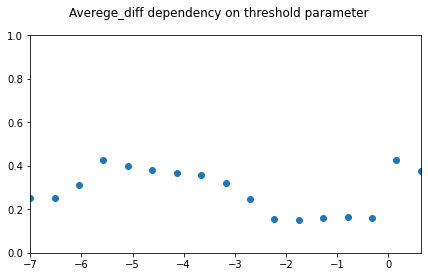

In [364]:
fig, axs = plt.subplots(figsize=(7, 4))
fig.suptitle('Averege_diff dependency on threshold parameter')

axs.scatter(log_samples, averege_diff)
axs.axis([log_samples[0], log_samples[-1], 0, 1])

plt.show()

In [298]:
averege_diff


[0.25180176879528005,
 0.2530468582360854,
 0.3135134978785097,
 0.42771253721891966,
 0.4009771294239254,
 0.37949664932262206,
 0.369204932428483,
 0.3559009465176791,
 0.3203596335437733,
 0.24580855191847767,
 0.1566617064381351,
 0.14997786466625218,
 0.1609131917204601,
 0.16356360713169046,
 0.16229529323819916,
 0.42472007763406117,
 0.37736095180781243]

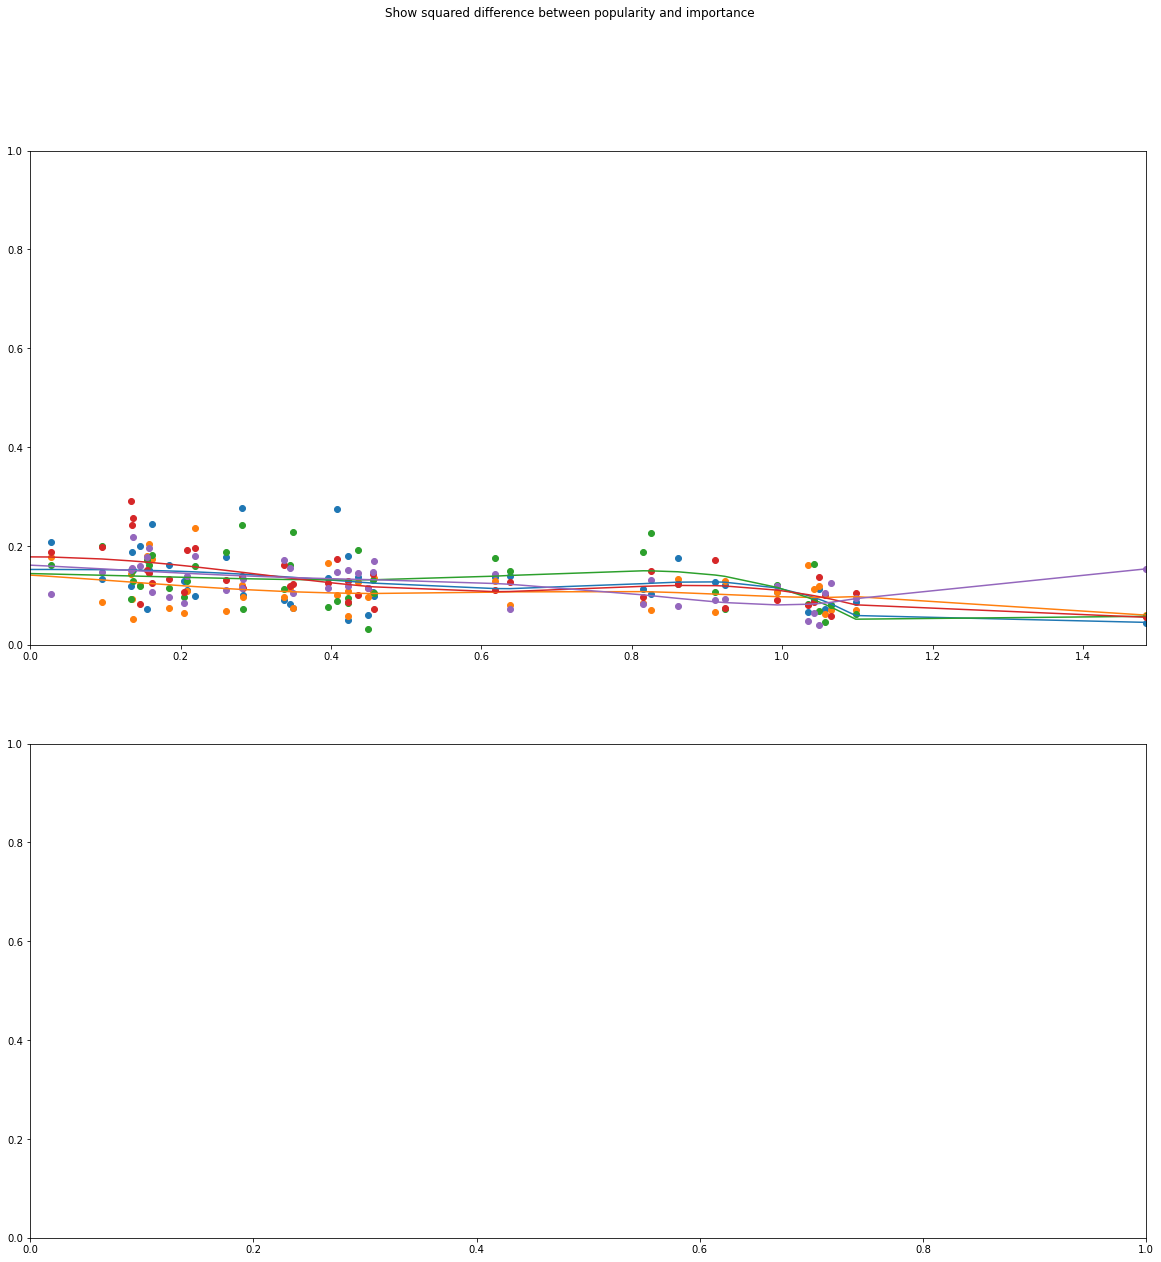

In [440]:
i = 0
diff_per_sample = np.zeros((len(loggs)//rep, len(loggs[0])))
log_sqr = np.log(np.array(list(sort_sqr_sample.values())))

while i!= len(loggs):
    diff_per_sample[i//5] += np.array(loggs[i])/rep
    i+=1
fig, axs = plt.subplots(2,figsize=(20, 20))
fig.suptitle('Show squared difference between popularity and importance')

d = 10
for sample in range(10, len(loggs)//rep - 2, 1):    
    axs[0].scatter(log_sqr, diff_per_sample[sample])
    axs[0].axis([0, max(log_sqr), 0, 1])
    theta = np.polyfit(log_sqr, diff_per_sample[sample], deg=d)
    model = np.poly1d(theta)
    axs[0].plot(log_sqr, model(log_sqr))
    delta = diff_per_sample[sample] - model(log_sqr)
plt.show()

    